In [1]:
import sys, os
import numpy as np
import pandas as pd
import scipy.stats as stat
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from helper_egsea import process_egsea_result

In [2]:
template_file = open('../template_script/egsea_template.R', 'r')
template_file_info = template_file.read()
template_file.close()

In [3]:
# load gene expression files in raw read count matrix format
expr_dir = '../data/count_matrix/'
all_file = os.listdir(expr_dir)
all_file.sort()
all_file

['AARS.txt',
 'AATF.txt',
 'ABCF1.txt',
 'ADAR.txt',
 'AGO1.txt',
 'AKAP1.txt',
 'AKAP8.txt',
 'AKAP8L.txt',
 'APOBEC3C.txt',
 'ASCC1.txt']

In [4]:
pathway_file = '../pathway_files/K562_DESEq2.gmt'

In [5]:
# directory for storing all output results
result_dir = '../example_results/EGSEA_results/'
# write the scripts for each target to a seperate R script to enable parallel running
script_dir = '../example_scripts/EGSEA_scripts/'

In [14]:
for expr_file in all_file:
    target = expr_file.split('.')[0]
    new_template_info = template_file_info.replace('TARGET_data_matrix.txt', expr_dir+expr_file)
    new_template_info = new_template_info.replace('pathway_file_name', pathway_file)
    new_template_info = new_template_info.replace('output_file', result_dir+target+'.egsea_result.txt')
    script = open(script_dir+target+'.r', 'w')
    script.write(new_template_info)
    script.close()        

Run the R scripts. And the results will be saved in example_results/EGSEA_results/

In [6]:
# for each underlying methods, generate separate scripts for more detailed results
all_egsea_methods = ["camera","roast","safe","gage","padog","plage",
                     "zscore","gsva","ssgsea","globaltest","ora" ]
for method in all_egsea_methods:
    if not os.path.exists('../example_scripts/'+method+'_egsea_scripts/'):
        os.mkdir('../example_results/'+method+'_egsea_results/')
        os.mkdir('../example_scripts/'+method+'_egsea_scripts/')

In [16]:
# for each underlying methods, generate separate scripts for more detailed results
template_file = open('../template_script/egsea_separate.R', 'r')
template_file_info_sep = template_file.read()
template_file.close()
for expr_file in all_file:
    for idx in range(len(all_egsea_methods)):
        pathway_method = pathway_file
        method = all_egsea_methods[idx]
        target = expr_file.split('.')[0]
        new_template_info = template_file_info_sep.replace('TARGET', expr_dir+expr_file)
        new_template_info = new_template_info.replace('pathway_file_name', pathway_file)
        new_template_info = new_template_info.replace('method_idx', str(idx+1))
        out_dir = '../example_results/'+method+'_egsea_results/'
        new_template_info = new_template_info.replace('output_file', out_dir+target+'.egsea.'+method+'.txt')
        script = open('../example_scripts/'+method+'_egsea_scripts/'+target+'.R', 'w')
        script.write(new_template_info)
        script.close()

Run scripts for each methods separately.

In [8]:
# extract EGSEA results and its underlying methods results
all_result_file = os.listdir(result_dir)
all_result_file.sort()
rank_dict = dict()
rank_dict['EGSEA'] = dict()
for m in all_egsea_methods:
    rank_dict[m] = dict()
    
for file in all_result_file:
    target = file.split('.')[0]
    df = pd.read_csv(result_dir+file, sep='\t', index_col=0)
    df['pathway_rank'] = stat.rankdata(df['avg.rank'])
    egsea_rank = df.loc[target]['pathway_rank']
    rank_dict['EGSEA'][target] = egsea_rank

# extract_results of underlying methods
for m in all_egsea_methods:
    rank_dict[m] = process_egsea_result('../example_results/'+m+'_egsea_results/')

In [14]:
rank_df = pd.DataFrame.from_dict(rank_dict)
rank_df

,EGSEA,camera,roast,safe,gage,padog,plage,zscore,gsva,ssgsea,globaltest,ora
AARS,11.0,1,153,126,104,43,118,103,104,35,NaN,1
AATF,1.0,11,6,101,115,19,61,20,51,13,NaN,21
ABCF1,5.0,2,134,119,128,24,83,20,10,5,NaN,28
ADAR,1.0,1,62,18,29,7,12,13,17,1,NaN,1
AGO1,24.0,11,1,29,33,88,25,6,28,3,NaN,24
AKAP1,2.0,4,9,36,44,9,28,4,39,3,NaN,3
AKAP8,3.0,4,10,2,2,2,1,2,2,2,NaN,21
AKAP8L,2.0,1,115,127,141,18,144,1,80,1,NaN,2
APOBEC3C,10.0,7,9,73,143,44,70,133,143,143,NaN,143
ASCC1,2.0,1,5,53,58,11,32,1,19,2,NaN,6


In [15]:
rank_df = pd.DataFrame.from_dict(rank_dict)
# write the results to seperate files
for m in rank_dict.keys():
    if m == 'globaltest':
        # this method cannot be run due to tehcnical issue
        continue
    rank_df[m].to_csv('../example_results/'+m+'_egsea_result.txt', sep='\t', header=None)

In [23]:
# plot all results
result_dfs = []
result_dir = '../Benchmark_results/'
methods_egsea = ['EGSEA']
methods_egsea.extend(all_egsea_methods)
methods_evaluated = []
for m in methods_egsea:
    if m == 'globaltest':
        continue
    if m == 'ora':
        m = 'ora_egsea'
    res_df = pd.read_csv(result_dir+m+'_result.txt', sep='\t', header=None, index_col=0)
    result_dfs.append(res_df)
    methods_evaluated.append(m)
# combine the results
all_result_df = pd.concat(result_dfs, axis=1)
all_result_df.columns = methods_evaluated
all_result_df

,EGSEA,camera,roast,safe,gage,padog,plage,zscore,gsva,ssgsea,ora_egsea
0,,,,,,,,,,,
AARS,11,1,153,126,104,43,118,103,104,35,1
AATF,1,11,6,101,115,19,61,20,51,13,21
ABCF1,5,2,134,119,128,24,83,20,10,5,28
ADAR,1,1,62,18,29,7,12,13,17,1,1
AGO1,15,11,1,29,33,88,25,6,28,3,24
...,...,...,...,...,...,...,...,...,...,...,...
XRCC6,1,3,23,22,24,17,62,2,10,3,1
XRN2,4,6,105,112,115,63,90,33,22,23,8
YBX3,3,21,19,40,51,73,28,28,44,2,1


In [24]:
def apk(predicted, k=10):
    """
    Computes the average precision at k.
    This function computes the average precision at k between two lists of items.
    """
    total_num = len(predicted)
    precision_list = []
    for idx in range(k):
        precision_list.append(np.where(predicted<=idx+1)[0].shape[0]/total_num)
        # print(np.where(predicted<=idx+1)[0].shape[0])
    # return P@10 and AP@10
    return precision_list[-1], np.mean(precision_list)

<AxesSubplot: ylabel='Ground truth pathway rank'>

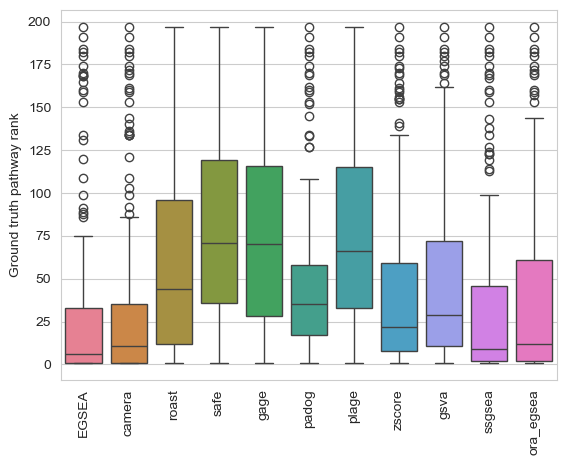

In [25]:
# plot the results
plt.xticks(rotation=90)
plt.ylabel('Ground truth pathway rank')
sns.boxplot(data=all_result_df)

<AxesSubplot: ylabel='Percent'>

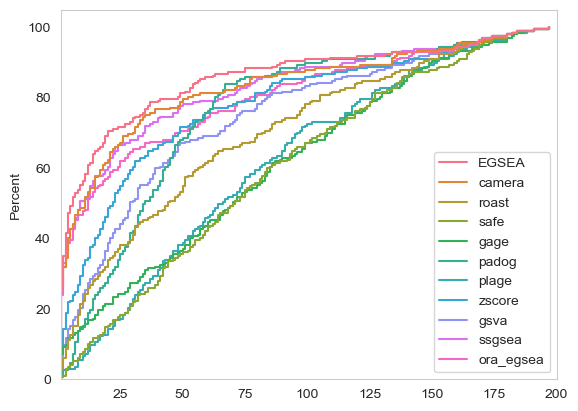

In [26]:
plt.grid(False)
plt.xlim(1, 200)
# plt.ylim(0, 100)
sns.ecdfplot(data=all_result_df, stat='percent')

In [27]:
for method in all_result_df.columns:
    print('-'*20)
    print(method, 'summary:')
    print('Median rank: ', all_result_df[method].median())
    print('Precision@10: ', apk(all_result_df[method])[0])
    print('Average Precision@10: ', apk(all_result_df[method])[1])

--------------------
EGSEA summary:
Median rank:  6.0
Precision@10:  0.5634517766497462
Average Precision@10:  0.46852791878172584
--------------------
camera summary:
Median rank:  11.0
Precision@10:  0.4873096446700508
Average Precision@10:  0.4121827411167513
--------------------
roast summary:
Median rank:  44.0
Precision@10:  0.2233502538071066
Average Precision@10:  0.13401015228426397
--------------------
safe summary:
Median rank:  71.0
Precision@10:  0.07614213197969544
Average Precision@10:  0.043147208121827416
--------------------
gage summary:
Median rank:  70.0
Precision@10:  0.15228426395939088
Average Precision@10:  0.11878172588832488
--------------------
padog summary:
Median rank:  35.0
Precision@10:  0.14720812182741116
Average Precision@10:  0.07461928934010152
--------------------
plage summary:
Median rank:  66.0
Precision@10:  0.06598984771573604
Average Precision@10:  0.0365482233502538
--------------------
zscore summary:
Median rank:  22.0
Precision@10:  0.32